In [1]:
import numpy as np
import pandas as pd
import nltk
from bs4 import BeautifulSoup
import re
import os
import codecs
from sklearn import feature_extraction
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import os  # for os.path.basename
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
import mpld3
from numpy import dot
from numpy.linalg import norm
from sklearn.metrics.pairwise import euclidean_distances
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Khuzaima\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Khuzaima\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Function and constants Declarations

In [53]:
#set up colors per cluster
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e',5: '#161515',6: '#FE172F',
                  7: '#5b9e77', 8: '#195f02', 9: '#1570b3', 10: '#17298a', 11: '#16a61e',12: '#761515',13: '#1E172F',
                  14: '#fb9e77', 15: '#995f02', 16: '#f570b3', 17: '#77298a', 18: '#f6a61e',19: '#f61515',20: '#7E172F'}

#set up cluster names 
cluster_names = {0: 'Cluster 0', 
                 1: 'Cluster 1', 
                 2: 'Cluster 2', 
                 3: 'Cluster 3', 
                 4: 'Cluster 4',
                 5: 'Cluster 5', 
                 6: 'Cluster 6',
                 7: 'Cluster 7', 
                 8: 'Cluster 8', 
                 9: 'Cluster 9', 
                 10: 'Cluster 10', 
                 11: 'Cluster 11',
                 12: 'Cluster 12', 
                 13: 'Cluster 13',
                 14: 'Cluster 14', 
                 15: 'Cluster 15', 
                 16: 'Cluster 16', 
                 17: 'Cluster 17', 
                 18: 'Cluster 18',
                 19: 'Cluster 19', 
                 20: 'Cluster 20'}

# Function for reading files
def readFiles(dir_name):
    files =  [os.path.join(dir_name,name) for name in os.listdir(dir_name)]
    return files

# Function for reading folders in directory
def readFolders(dir_name):
    dirs =  [name for name in os.listdir(dir_name) if os.path.isdir(name)]
    return dirs


# Tokenize and stem text
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

# Only tokenize the text
def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

# This function creates a dic with folder names as keys as all the file texts as values in form of a list
def wordDic(folder_list):
    dic ={}
    for current_folder in folder_list:
        print("processing folder",current_folder)
        all_text=[]
        files = readFiles(os.path.join(os.getcwd(),current_folder))
        for current_file in files:
            text = open(current_file,encoding='Latin-1').read().split()
            text = ' '.join(text)
            all_text.append(text)
        dic[current_folder]= all_text        
    return dic

# This function splits the files and then joins text in those files into one 
def split(dic,split_ratio = 0.2):
    word_list_complete=[]
    word_list_train = []
    word_list_test = [] 
    for grp_name,all_text in word_dic.items():
        print(grp_name,"contains", len(all_text))
        train, test = train_test_split(all_text, test_size = split_ratio)
        current_txt_train = ' '.join(train)
        current_txt_test = ' '.join(test)
        current_txt_complete = ' '.join(all_text)
        word_list_complete.append(current_txt_complete)
        word_list_train.append(current_txt_train)
        word_list_test.append(current_txt_test)
    return word_list_complete, word_list_train , word_list_test

# Create tfidf for train and test
def tfidf(word_list,word_list_train,word_list_test):
    tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,2))
    # Fit and transform on training set
    tfidf_matrix_train = tfidf_vectorizer.fit_transform(word_list_train)
    # Transform test set based on training set
    tfidf_matrix_test = tfidf_vectorizer.transform(word_list_test)
    print(tfidf_matrix_train.shape,tfidf_matrix_test.shape)
    return tfidf_matrix_train,tfidf_matrix_test

# Compute distances using cosine similarity
def compute_dist(tfidf_matrix_train,tfidf_matrix_test):
    dist_train = 1 - cosine_similarity(tfidf_matrix_train)
    dist_test = 1 - cosine_similarity(tfidf_matrix_test)
    return dist_train,dist_test

# Make clusters and returns clusters and centroids
def make_clusters(num_clusters):
    
    km_train = KMeans(n_clusters = num_clusters)
    km_test = KMeans(n_clusters = num_clusters)
    km_train.fit(tfidf_matrix_train)
    km_test.fit(tfidf_matrix_test)
    clusters_train = km_train.labels_.tolist()
    clusters_test = km_test.labels_.tolist()
    return clusters_train,clusters_test,km_train.cluster_centers_,km_test.cluster_centers_

# Create dataframe of resultant clusters
def create_df(titles,clusters_train,clusters_test):
    training = { 'News Group': titles,  'Cluster': clusters_train}
    testing = { 'News Group': titles,  'Cluster': clusters_test}

    df_train = pd.DataFrame(training, index = [clusters_train] , columns = ['News Group','Cluster'])
    df_test = pd.DataFrame(testing, index = [clusters_test] , columns = ['News Group','Cluster'])

    return df_train,df_test

# Transform the distances for better visualization
def mds_transform(dist_train,dist_test):
    # two components as we're plotting points in a two-dimensional plane
    # "precomputed" because we provide a distance matrix
    # we will also specify `random_state` so the plot is reproducible.
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

    pos_train = mds.fit_transform(dist_train)  # shape (n_components, n_samples)
    pos_test = mds.fit_transform(dist_test)  # shape (n_components, n_samples)


    xs_train, ys_train = pos_train[:, 0], pos_train[:, 1]

    xs_test, ys_test = pos_test[:, 0], pos_test[:, 1]
    
    return xs_train,ys_train,xs_test,ys_test

# Visulaize clusters
def plot_clusters(cluster_colors,cluster_names,xs,ys,clusters,titles):
    #create data frame that has the result of the MDS plus the cluster numbers and titles
    df = pd.DataFrame(dict(x=xs, y=ys, label=clusters,title=titles)) 

    #group by cluster
    groups = df.groupby('label')


    # set up plot
    fig, ax = plt.subplots(figsize=(17, 9)) # set size
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    #iterate through groups to layer the plot
    #note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
    for name, group in groups:
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
        ax.set_aspect('auto')
        ax.tick_params(\
            axis= 'x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelbottom='off')
        ax.tick_params(\
            axis= 'y',         # changes apply to the y-axis
            which='both',      # both major and minor ticks are affected
            left='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelleft='off')
        
    ax.legend(numpoints=1)  #show legend with only 1 point

    #add label in x,y position with the label as the film title
    for i in range(len(df)):
        ax.text(df.loc[i]['x'], df.loc[i]['y'],  df.loc[i]['title'], size=8)  

        
        
    plt.show() #show the plot
    plt.close()
    #uncomment the below to save the plot if need be
    #plt.savefig('clusters_small_noaxes.png', dpi=200)

# External evauation for k = 6
def calculate_purity(df):
    classes = { 0:['comp.graphics','comp.os.ms-windows.misc','comp.sys.ibm.pc.hardware','comp.sys.mac.hardware','comp.windows.x'],
            1:['rec.autos','rec.motorcycles','rec.sport.baseball','rec.sport.hockey'],
            2:['sci.crypt','sci.electronics','sci.med','sci.space'],
            3:['misc.forsale'],
            4:['talk.politics.misc','talk.politics.guns','talk.politics.mideast'],
            5:['talk.religion.misc','alt.atheism','soc.religion.christian']
        }
    
    purities =[]
    for i in range(0,6):
        cluster_length = df[df['Cluster']==i]["News Group"].count()
        cluster_mt = list(df[df['Cluster']==i]["News Group"])
        
        class_lengths = list()
        for k, titles in classes.items():
            count = 0
            for t in cluster_mt:
                if t in titles:
                    count+=1
            class_lengths.append(count)

        max_class_length = np.max(np.array(class_lengths))
        purity = max_class_length / cluster_length
        purities.append(purity)
    return purities

# For internal evaluation, I have computed max and avg inter cluster distance utilizing centroids provided by the k means algo.
def intercluster_distances(centroids):
    dists = euclidean_distances(centroids)
    max_dist, avg_dist = dists.max(), dists.mean()
    return max_dist,avg_dist

# This function will be used to test all possible values of k
def do_magic():
    ks = [3,6,12,20]
    for k in ks:
        print('\n\n--------------------------------- K =',k,'-----------------------------')
        clusters_train,clusters_test,centroids_train,centroids_test= make_clusters(k)
        df_train,df_test = create_df(list(word_dic.keys()),clusters_train,clusters_test)
        xs_train,ys_train,xs_test,ys_test = mds_transform(dist_train,dist_test)
        #visualize training clusters
        print('\nVisulaizing training cluster\n')
        plot_clusters(cluster_colors,cluster_names,xs_train,ys_train,clusters_train,list(word_dic.keys()))
        # Inter-cluster distance for train set
        max_dist,avg_dist = intercluster_distances(centroids_train)
        print("Max Inter-Cluster distance for train",max_dist)
        print("Mean Inter-Cluster distance for train",avg_dist)
        # Visualize testing clusters
        print('\nvisualizing test clusters\n')
        plot_clusters(cluster_colors,cluster_names,xs_test,ys_test,clusters_test,list(word_dic.keys()))
        # Inter-cluster for test
        max_dist,avg_dist = intercluster_distances(centroids_test)
        print("Max Inter-Cluster distance for test",max_dist)
        print("Mean Inter-Cluster distance for test",avg_dist)

        if k ==6:
            # Externally evaluate by using purity
            train_purities = calculate_purity(df_train) 
            test_purities = calculate_purity(df_test)
            print("\nPurity on Training data ")
            for idx,purity in enumerate(train_purities):
                print("Purity for cluster",idx,":",purity)
            print("\nPurity on Testing data ")
            for idx,purity in enumerate(test_purities):
                print("Purity for cluster",idx,":",purity)

# Split ratio 0.2

In [47]:
folder_list = readFolders(os.getcwd())
word_dic = wordDic(folder_list)
word_list_complete, word_list_train , word_list_test = split(word_dic,0.2)
tfidf_matrix_train,tfidf_matrix_test = tfidf(word_list_complete, word_list_train , word_list_test)
dist_train,dist_test = compute_dist(tfidf_matrix_train,tfidf_matrix_test)

processing folder alt.atheism
processing folder comp.graphics
processing folder comp.os.ms-windows.misc
processing folder comp.sys.ibm.pc.hardware
processing folder comp.sys.mac.hardware
processing folder comp.windows.x
processing folder misc.forsale
processing folder rec.autos
processing folder rec.motorcycles
processing folder rec.sport.baseball
processing folder rec.sport.hockey
processing folder sci.crypt
processing folder sci.electronics
processing folder sci.med
processing folder sci.space
processing folder soc.religion.christian
processing folder talk.politics.guns
processing folder talk.politics.mideast
processing folder talk.politics.misc
processing folder talk.religion.misc
alt.atheism contains 1000
comp.graphics contains 1000
comp.os.ms-windows.misc contains 1000
comp.sys.ibm.pc.hardware contains 1000
comp.sys.mac.hardware contains 1000
comp.windows.x contains 1000
misc.forsale contains 1000
rec.autos contains 1000
rec.motorcycles contains 1000
rec.sport.baseball contains 10



--------------------------------- K = 3 -----------------------------

Visulaizing training cluster



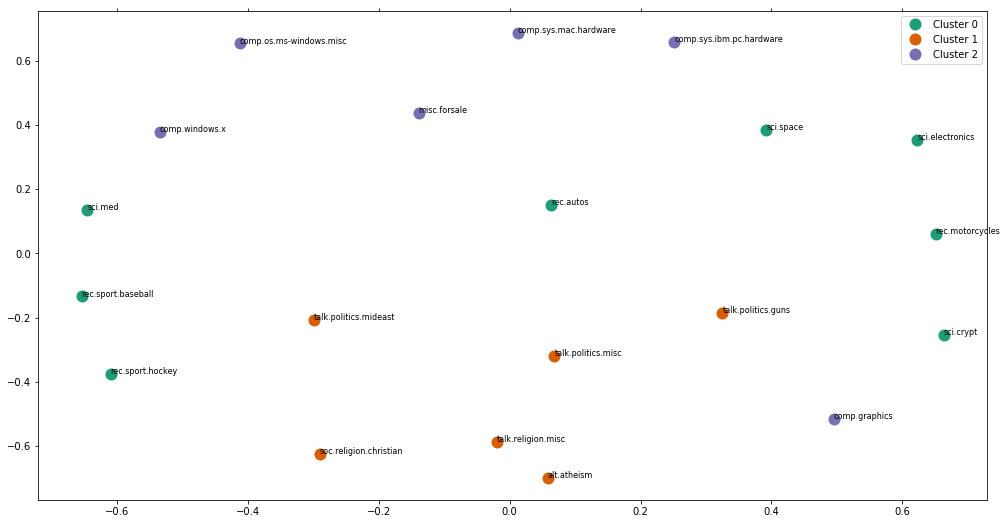

Max Inter-Cluster distance for train 0.7143401678595467
Mean Inter-Cluster distance for train 0.4311108193949573

visualizing test clusters



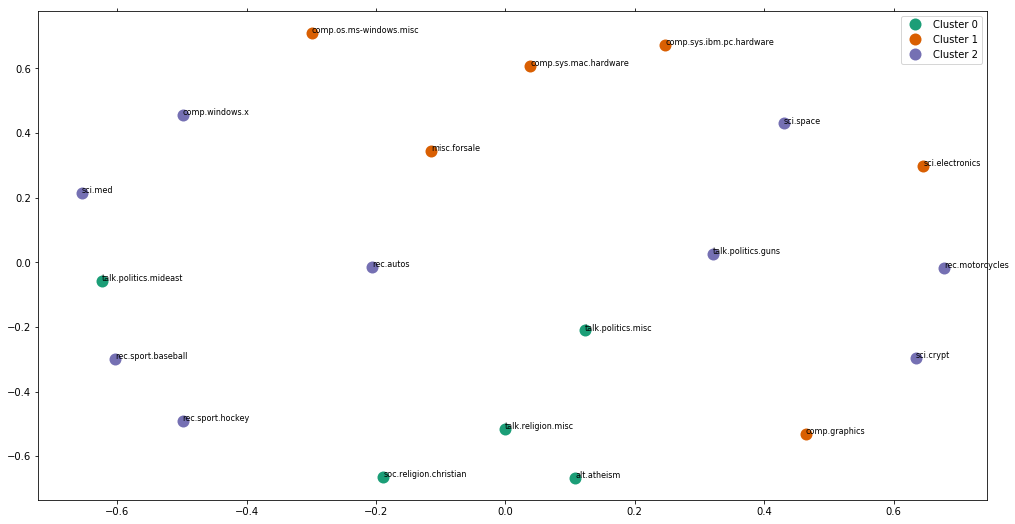

Max Inter-Cluster distance for test 0.7290926704698205
Mean Inter-Cluster distance for test 0.4274337454850437


--------------------------------- K = 6 -----------------------------

Visulaizing training cluster



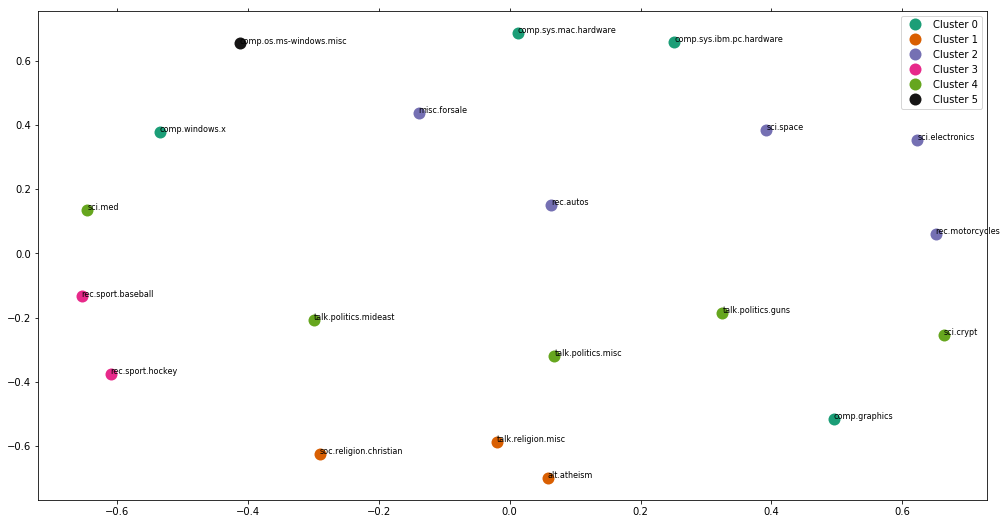

Max Inter-Cluster distance for train 1.2671957173499089
Mean Inter-Cluster distance for train 0.8029883083499595

visualizing test clusters



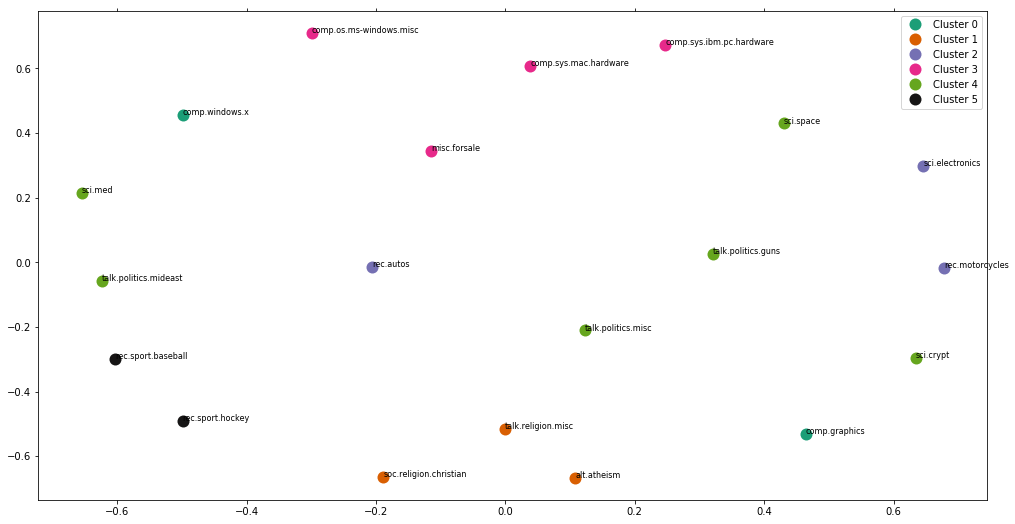

Max Inter-Cluster distance for test 1.0502634628119494
Mean Inter-Cluster distance for test 0.7458528808933615

Purity on Training data 
Purity for cluster 0 : 1.0
Purity for cluster 1 : 1.0
Purity for cluster 2 : 0.4
Purity for cluster 3 : 1.0
Purity for cluster 4 : 0.6
Purity for cluster 5 : 1.0

Purity on Testing data 
Purity for cluster 0 : 1.0
Purity for cluster 1 : 1.0
Purity for cluster 2 : 0.6666666666666666
Purity for cluster 3 : 0.75
Purity for cluster 4 : 0.5
Purity for cluster 5 : 1.0


--------------------------------- K = 12 -----------------------------

Visulaizing training cluster



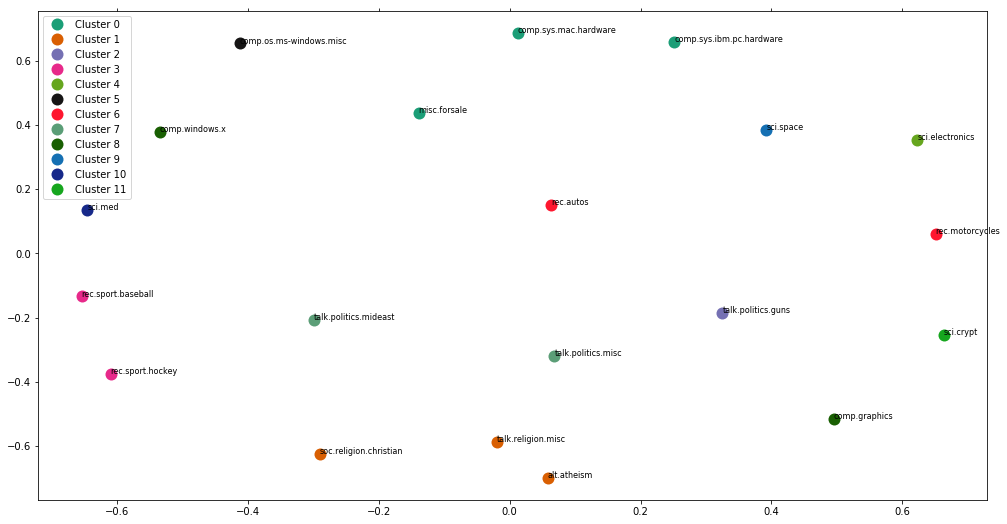

Max Inter-Cluster distance for train 1.4137978071132362
Mean Inter-Cluster distance for train 1.1126273901251773

visualizing test clusters



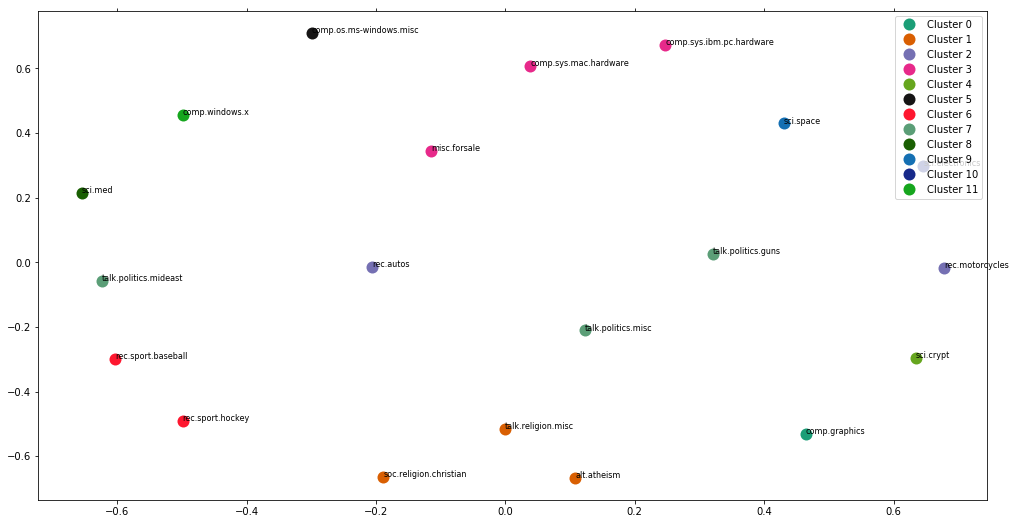

Max Inter-Cluster distance for test 1.4136071580289395
Mean Inter-Cluster distance for test 1.129152270798801


--------------------------------- K = 20 -----------------------------

Visulaizing training cluster



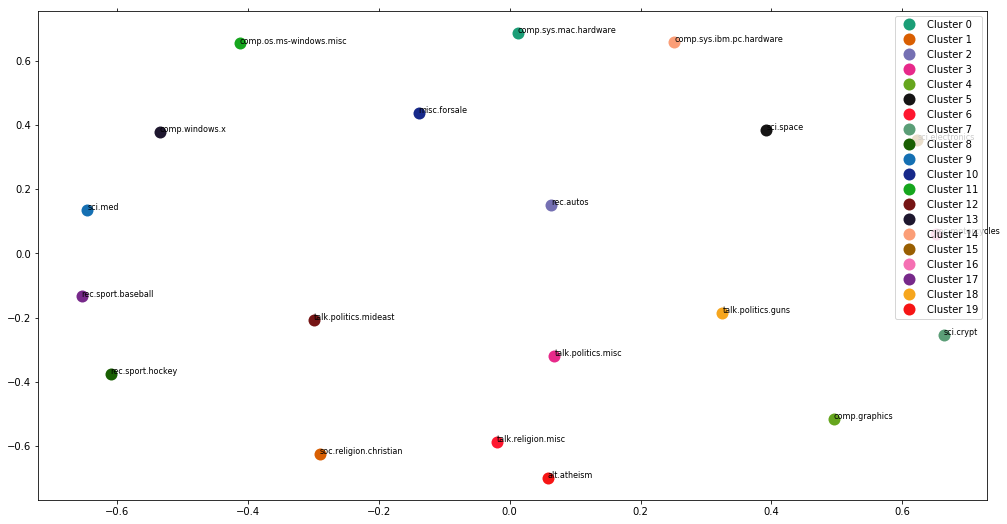

Max Inter-Cluster distance for train 1.414019345381004
Mean Inter-Cluster distance for train 1.3110713351855363

visualizing test clusters



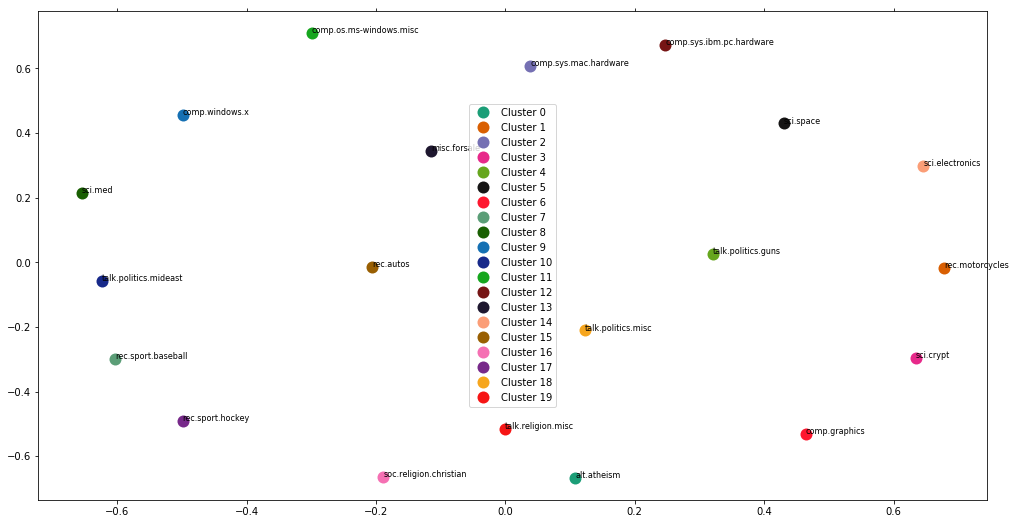

Max Inter-Cluster distance for test 1.4139991653345456
Mean Inter-Cluster distance for test 1.3143063588649386


In [54]:
#all tests for split ratio 0.2
do_magic()

# Split Ratio 0.5

In [55]:
folder_list = readFolders(os.getcwd())
word_dic = wordDic(folder_list)
word_list_complete, word_list_train , word_list_test = split(word_dic,0.5)
tfidf_matrix_train,tfidf_matrix_test = tfidf(word_list_complete, word_list_train , word_list_test)
dist_train,dist_test = compute_dist(tfidf_matrix_train,tfidf_matrix_test)

processing folder alt.atheism
processing folder comp.graphics
processing folder comp.os.ms-windows.misc
processing folder comp.sys.ibm.pc.hardware
processing folder comp.sys.mac.hardware
processing folder comp.windows.x
processing folder misc.forsale
processing folder rec.autos
processing folder rec.motorcycles
processing folder rec.sport.baseball
processing folder rec.sport.hockey
processing folder sci.crypt
processing folder sci.electronics
processing folder sci.med
processing folder sci.space
processing folder soc.religion.christian
processing folder talk.politics.guns
processing folder talk.politics.mideast
processing folder talk.politics.misc
processing folder talk.religion.misc
alt.atheism contains 1000
comp.graphics contains 1000
comp.os.ms-windows.misc contains 1000
comp.sys.ibm.pc.hardware contains 1000
comp.sys.mac.hardware contains 1000
comp.windows.x contains 1000
misc.forsale contains 1000
rec.autos contains 1000
rec.motorcycles contains 1000
rec.sport.baseball contains 10



--------------------------------- K = 3 -----------------------------

Visulaizing training cluster



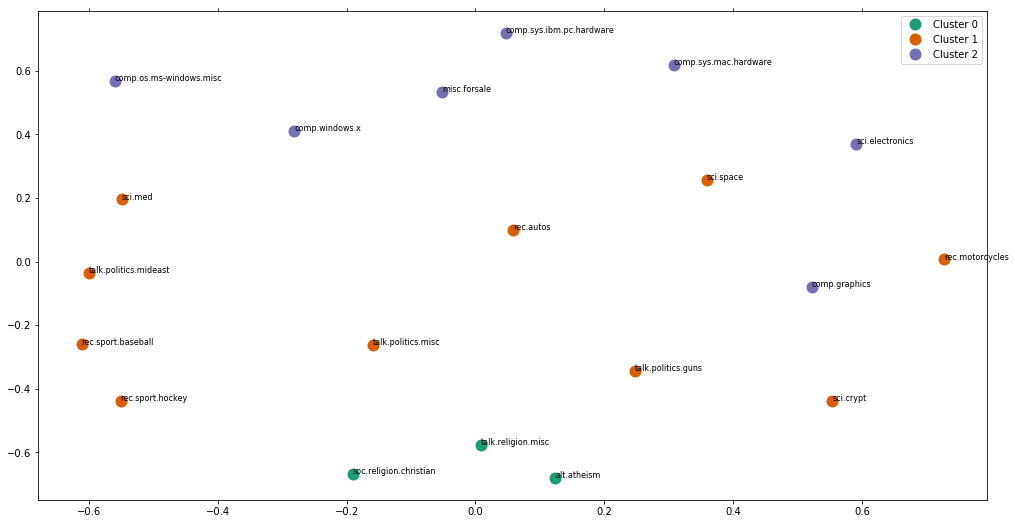

Max Inter-Cluster distance for train 0.8924289490971318
Mean Inter-Cluster distance for train 0.5032292370654695

visualizing test clusters



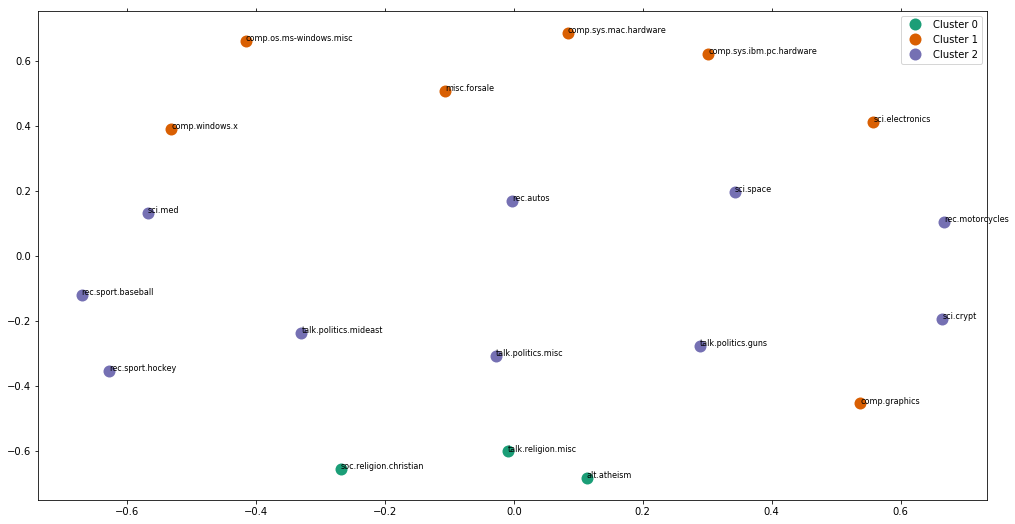

Max Inter-Cluster distance for test 0.8708467286596985
Mean Inter-Cluster distance for test 0.49130975410663513


--------------------------------- K = 6 -----------------------------

Visulaizing training cluster



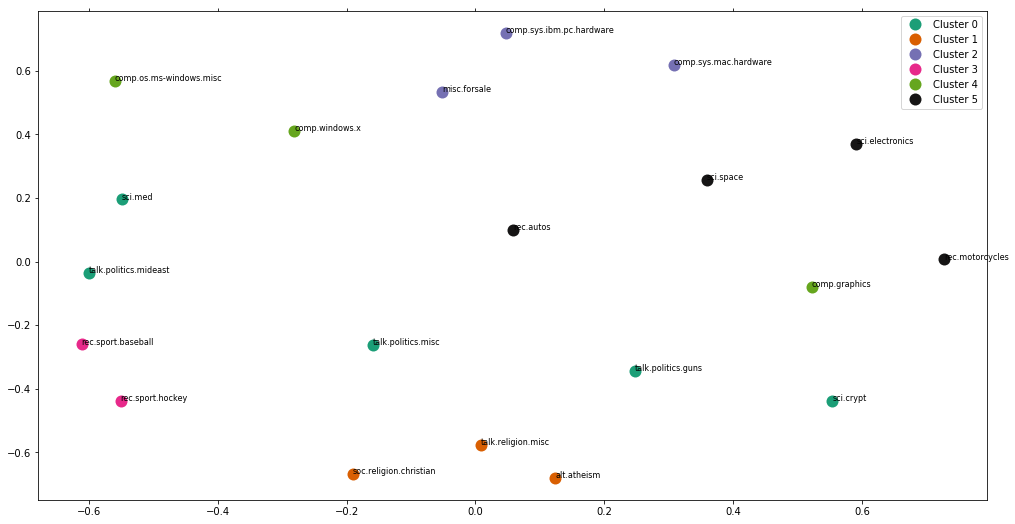

Max Inter-Cluster distance for train 1.1005613741722018
Mean Inter-Cluster distance for train 0.7546309990216895

visualizing test clusters



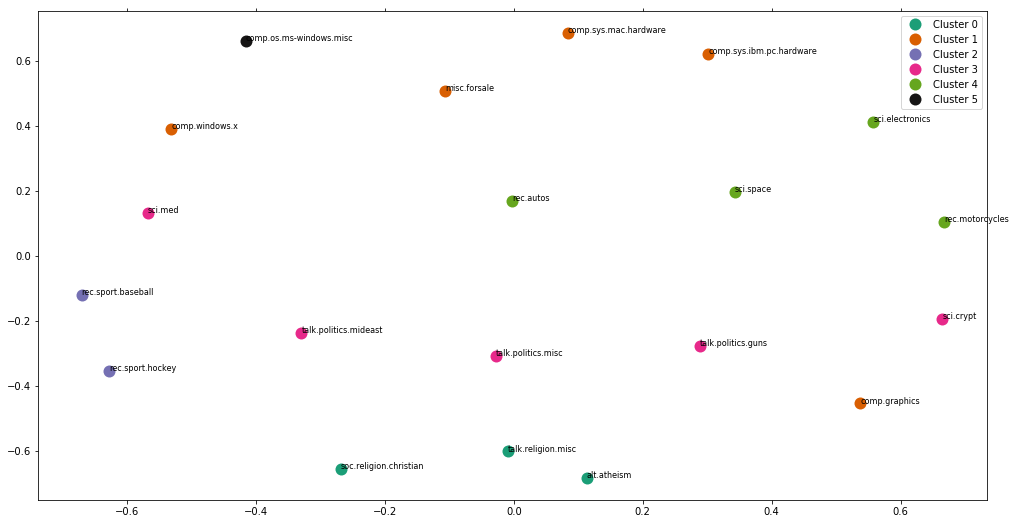

Max Inter-Cluster distance for test 1.2870433086689952
Mean Inter-Cluster distance for test 0.813437353254915

Purity on Training data 
Purity for cluster 0 : 0.6
Purity for cluster 1 : 1.0
Purity for cluster 2 : 0.6666666666666666
Purity for cluster 3 : 1.0
Purity for cluster 4 : 1.0
Purity for cluster 5 : 0.5

Purity on Testing data 
Purity for cluster 0 : 1.0
Purity for cluster 1 : 0.8
Purity for cluster 2 : 1.0
Purity for cluster 3 : 0.6
Purity for cluster 4 : 0.5
Purity for cluster 5 : 1.0


--------------------------------- K = 12 -----------------------------

Visulaizing training cluster



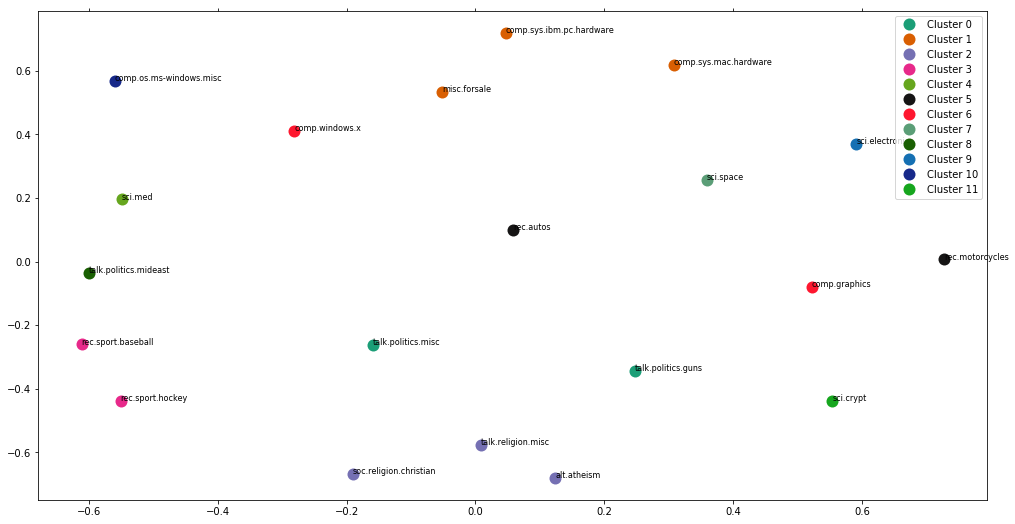

Max Inter-Cluster distance for train 1.4139460912135096
Mean Inter-Cluster distance for train 1.1180841677873257

visualizing test clusters



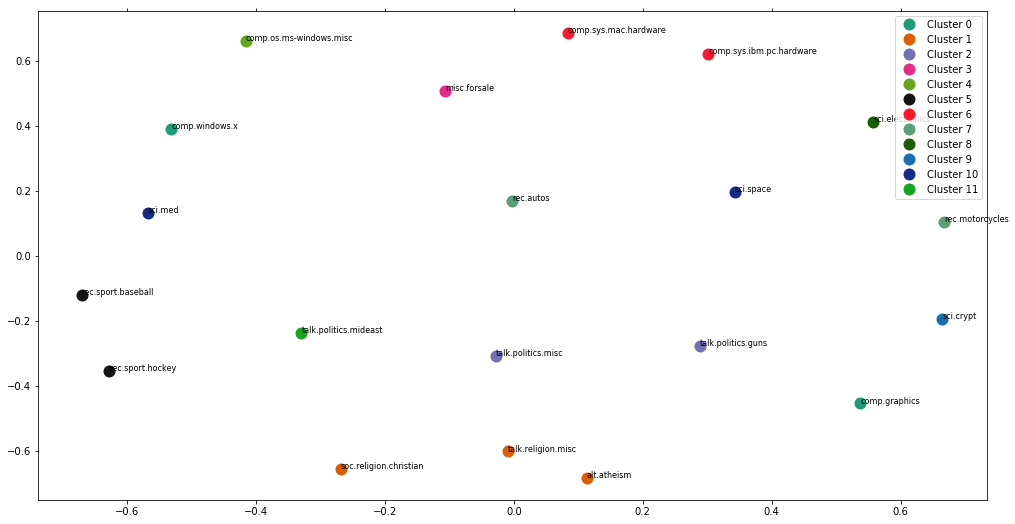

Max Inter-Cluster distance for test 1.4139673289421753
Mean Inter-Cluster distance for test 1.0976940056417803


--------------------------------- K = 20 -----------------------------

Visulaizing training cluster



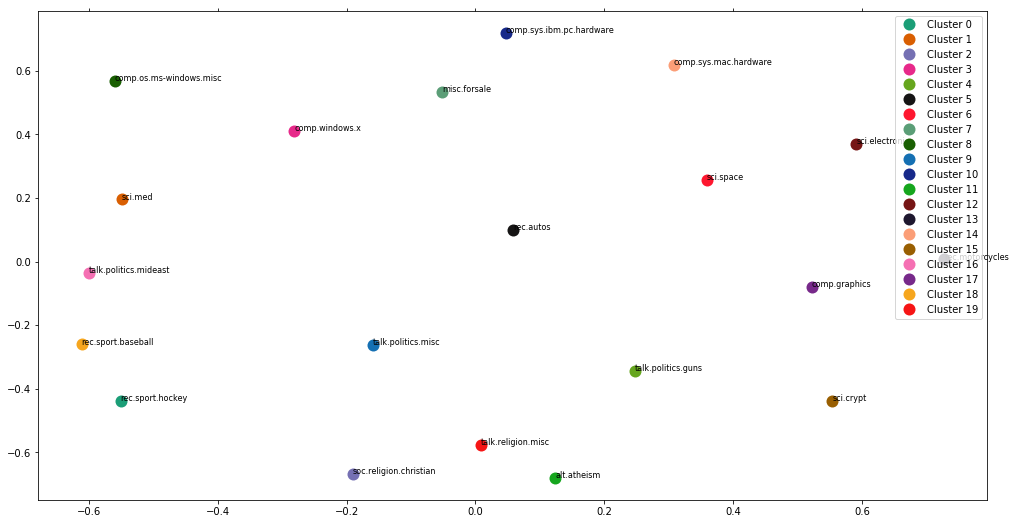

Max Inter-Cluster distance for train 1.4139460912135096
Mean Inter-Cluster distance for train 1.3009414722838877

visualizing test clusters



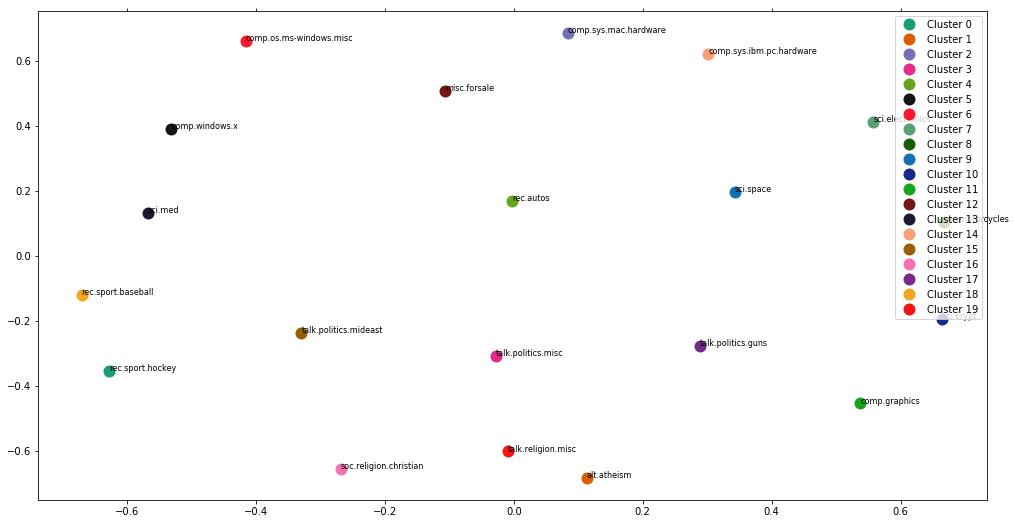

Max Inter-Cluster distance for test 1.4139673289421753
Mean Inter-Cluster distance for test 1.3038993765992963


In [56]:
#all tests for split ratio 0.5
do_magic()

# Split Ratio 0.7

In [57]:
folder_list = readFolders(os.getcwd())
word_dic = wordDic(folder_list)
word_list_complete, word_list_train , word_list_test = split(word_dic,0.7)
tfidf_matrix_train,tfidf_matrix_test = tfidf(word_list_complete, word_list_train , word_list_test)
dist_train,dist_test = compute_dist(tfidf_matrix_train,tfidf_matrix_test)

processing folder alt.atheism
processing folder comp.graphics
processing folder comp.os.ms-windows.misc
processing folder comp.sys.ibm.pc.hardware
processing folder comp.sys.mac.hardware
processing folder comp.windows.x
processing folder misc.forsale
processing folder rec.autos
processing folder rec.motorcycles
processing folder rec.sport.baseball
processing folder rec.sport.hockey
processing folder sci.crypt
processing folder sci.electronics
processing folder sci.med
processing folder sci.space
processing folder soc.religion.christian
processing folder talk.politics.guns
processing folder talk.politics.mideast
processing folder talk.politics.misc
processing folder talk.religion.misc
alt.atheism contains 1000
comp.graphics contains 1000
comp.os.ms-windows.misc contains 1000
comp.sys.ibm.pc.hardware contains 1000
comp.sys.mac.hardware contains 1000
comp.windows.x contains 1000
misc.forsale contains 1000
rec.autos contains 1000
rec.motorcycles contains 1000
rec.sport.baseball contains 10



--------------------------------- K = 3 -----------------------------

Visulaizing training cluster



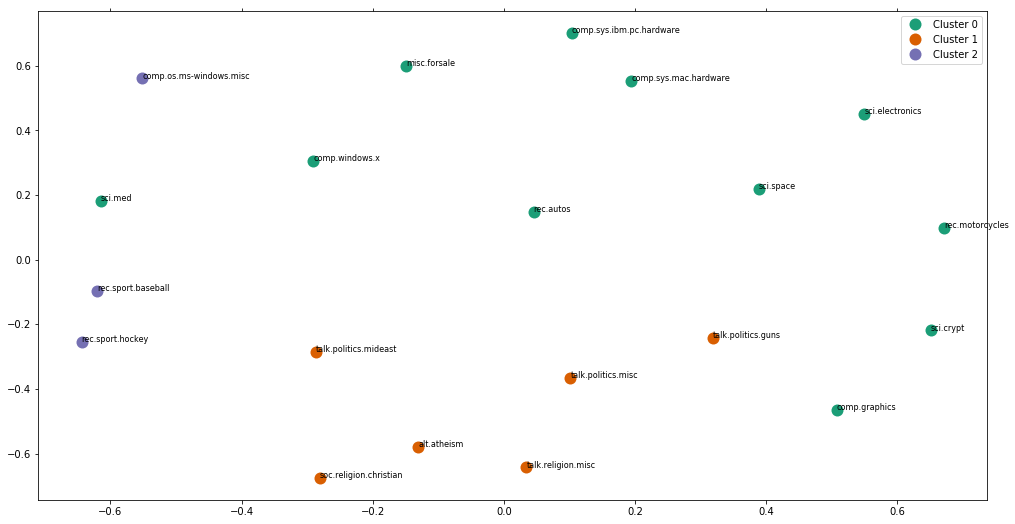

Max Inter-Cluster distance for train 0.8445004781418589
Mean Inter-Cluster distance for train 0.49496476565124087

visualizing test clusters



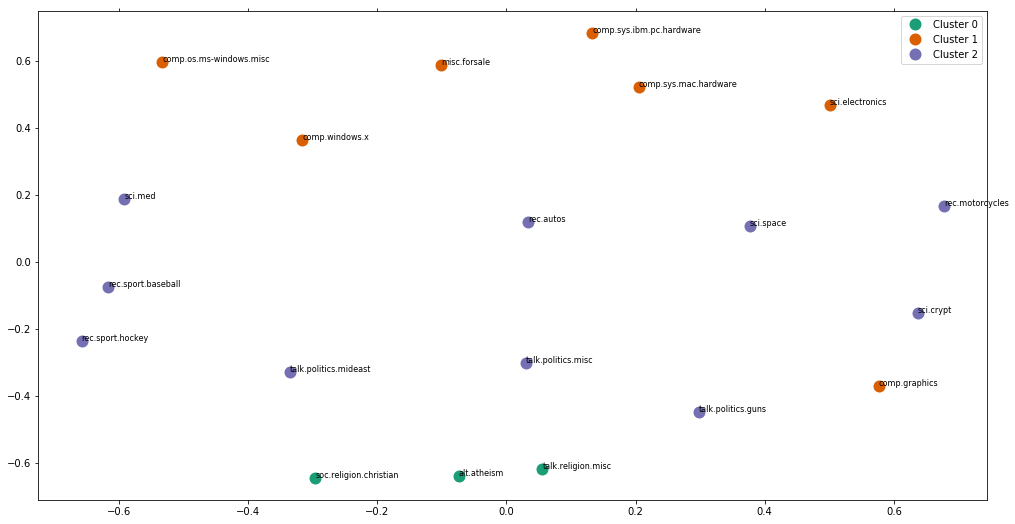

Max Inter-Cluster distance for test 0.9029198583154265
Mean Inter-Cluster distance for test 0.5077371148873241


--------------------------------- K = 6 -----------------------------

Visulaizing training cluster



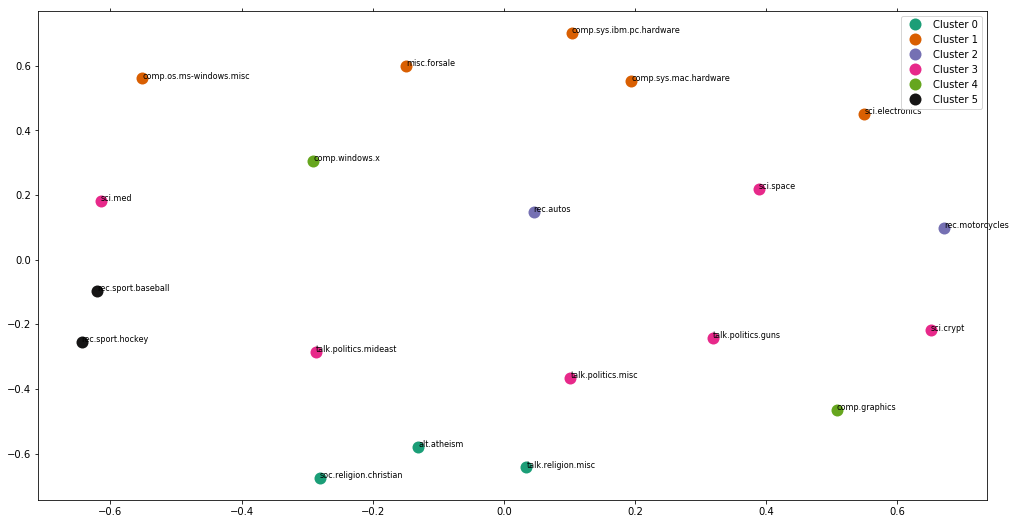

Max Inter-Cluster distance for train 1.130515674188508
Mean Inter-Cluster distance for train 0.7995534718411479

visualizing test clusters



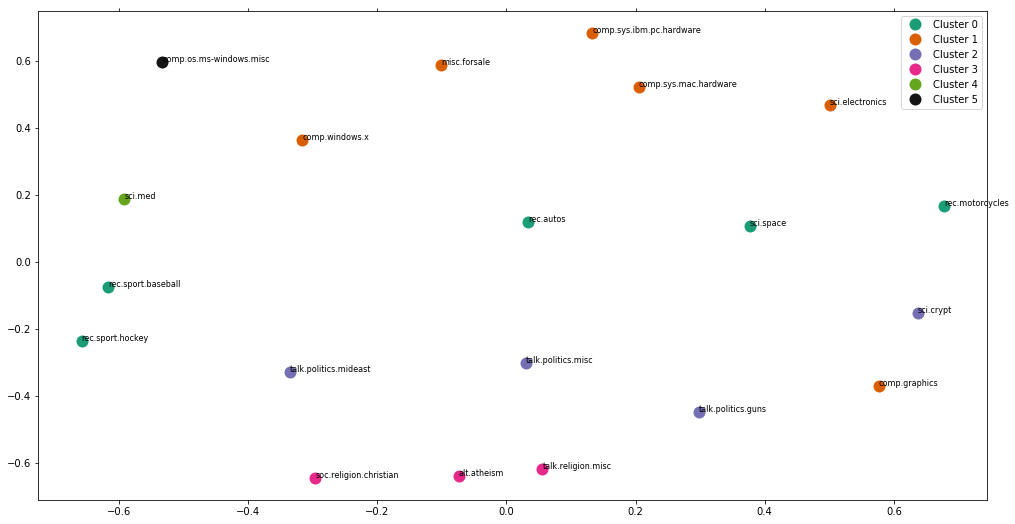

Max Inter-Cluster distance for test 1.4136055768023847
Mean Inter-Cluster distance for test 0.8643354009469605

Purity on Training data 
Purity for cluster 0 : 1.0
Purity for cluster 1 : 0.6
Purity for cluster 2 : 1.0
Purity for cluster 3 : 0.5
Purity for cluster 4 : 1.0
Purity for cluster 5 : 1.0

Purity on Testing data 
Purity for cluster 0 : 0.8
Purity for cluster 1 : 0.6666666666666666
Purity for cluster 2 : 0.75
Purity for cluster 3 : 1.0
Purity for cluster 4 : 1.0
Purity for cluster 5 : 1.0


--------------------------------- K = 12 -----------------------------

Visulaizing training cluster



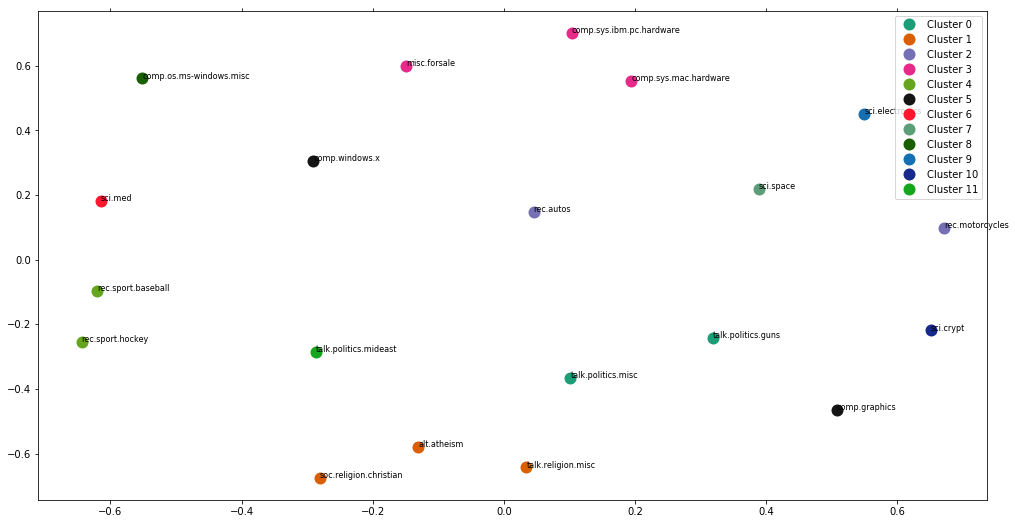

Max Inter-Cluster distance for train 1.4126901730177006
Mean Inter-Cluster distance for train 1.1204233621761093

visualizing test clusters



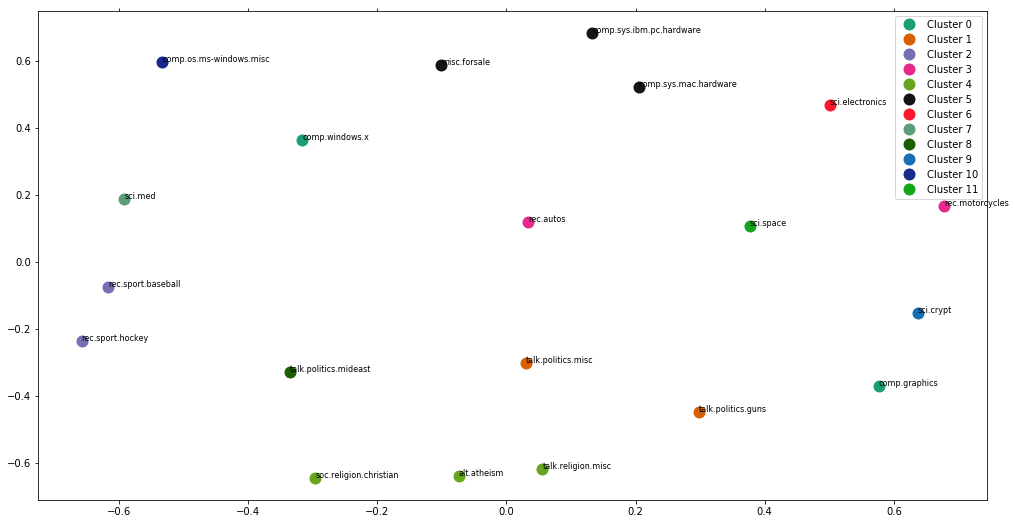

Max Inter-Cluster distance for test 1.4138802882242394
Mean Inter-Cluster distance for test 1.123100143559184


--------------------------------- K = 20 -----------------------------

Visulaizing training cluster



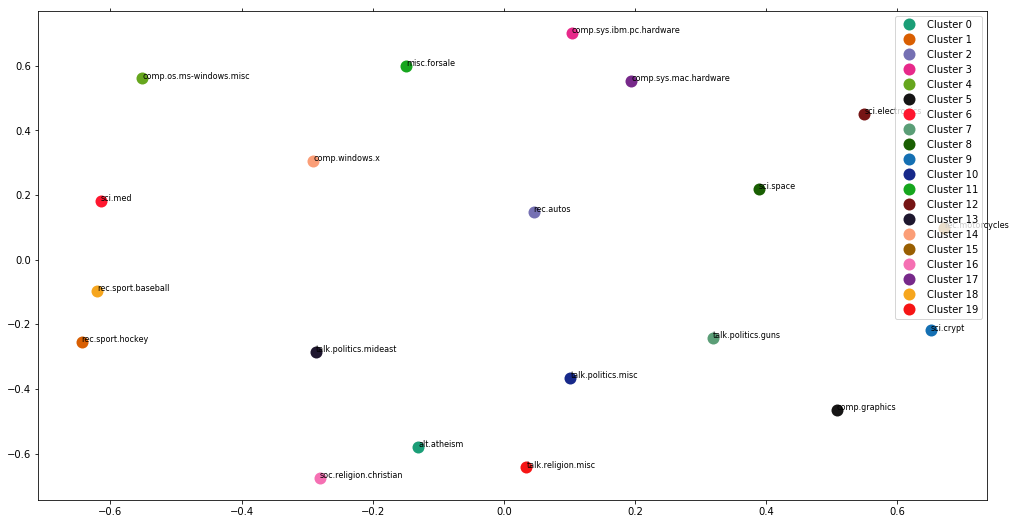

Max Inter-Cluster distance for train 1.4127561150988432
Mean Inter-Cluster distance for train 1.2919877127990549

visualizing test clusters



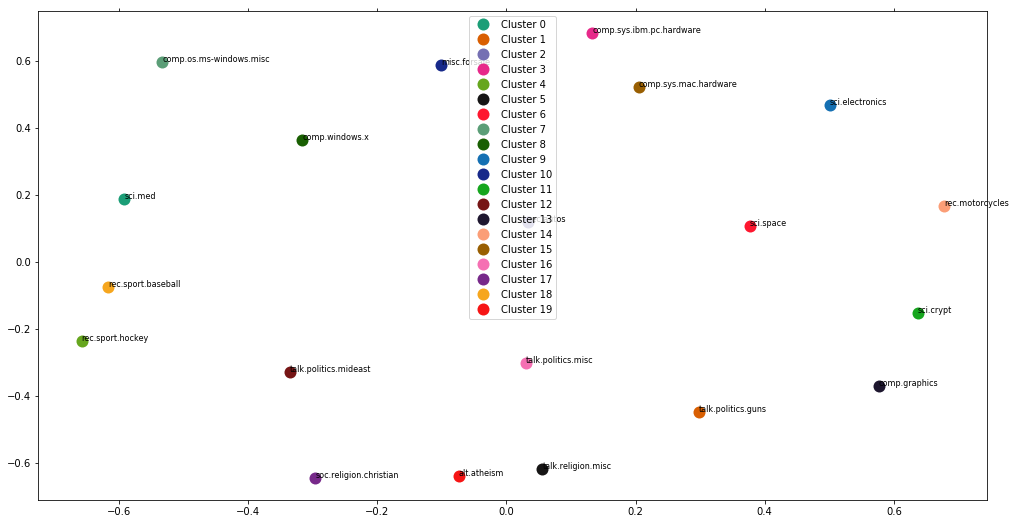

Max Inter-Cluster distance for test 1.4138802882242394
Mean Inter-Cluster distance for test 1.2906967163700998


In [58]:
#all tests for split ratio 0.7
do_magic()